In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
import seaborn as sns
from joblib import load
sns.set(context = 'talk')

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


os.chdir('/content/drive/My Drive/DCASE/src')
from utils import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Define Prototype Layer

In [0]:
class ProtoLayer(nn.Module):
    def __init__(self, n_proto, proto_channels, proto_h, proto_w):
        super(ProtoLayer,self).__init__()
        self.prototypes = nn.Parameter(
                          torch.rand(n_proto, proto_channels, proto_h, proto_w))

        self.n_proto = n_proto
        self.n_channels = proto_channels
        self.hp = proto_h
        self.wp = proto_w

    def forward(self, x):
        ones = torch.ones(self.prototypes.shape).to(device)
        x2 = x ** 2
        x2_patch_sum = F.conv2d(x2, ones)

        p2 = self.prototypes ** 2
        p2 = torch.sum(p2, dim = (1,2,3))

        p2_reshape = p2.view(-1, 1, 1)               

        xp = F.conv2d(x, self.prototypes)

        return x2_patch_sum - 2 * xp + p2_reshape


# Define Prototype Model

In [0]:
class AProtoPNet(nn.Module):
    def __init__(self):
        super(AProtoPNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding = 2, bias = False)
        self.conv2 = nn.Conv2d(8, 8, 5, padding = 2, bias = False)
        self.conv3 = nn.Conv2d(8, 16, 5, padding = 2, bias = False)
        self.conv4 = nn.Conv2d(16, 16, 5, padding = 2, bias = False)
        self.proto_layer = ProtoLayer(3, 16, 6,6)

    def forward(self, x):
        # x -> (batch, C, H, W), C = 1, H = 128, W = 157
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)  # x -> (batch, 8, 64, 78)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)  # x -> (batch, 8, 32, 39)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)  # x -> (batch, 16, 16, 19)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)  # x -> (batch, 16, 8, 9)
        x = self.proto_layer(x) # x -> (batch, n_proto, 8 - hp + 1, 9 - hp + 1)
        x = (-F.max_pool2d(-x, (x.shape[-2],x.shape[-1]))).view(-1,x.shape[1])
        # x -> (batch, n_proto)
        return x

    def project_prototypes(self, x):
        with torch.no_grad():
            x = F.max_pool2d(F.relu(self.conv1(x)), 2)  # x -> (batch, 8, 64, 78)
            x = F.max_pool2d(F.relu(self.conv2(x)), 2)  # x -> (batch, 8, 32, 39)
            x = F.max_pool2d(F.relu(self.conv3(x)), 2)  # x -> (batch, 16, 16, 19)
            x = F.max_pool2d(F.relu(self.conv4(x)), 2)  # x -> (batch, 16, 8, 9)
            proto_out = self.proto_layer(x) # proto_out -> (batch, n_proto, 8 - hp + 1, 9 - hp + 1)
        
            n_samples, n_proto, ho, wo = proto_out.shape 

            for indx_proto in range(n_proto):
                min_dist = np.inf
                for indx_sample in range(n_samples):
                    for h in range(ho):
                        for w in range(wo):
                            if proto_out[indx_sample,indx_proto, h, w].item() < min_dist:
                                h_min = h
                                w_min = w
                                indx_sample_min = indx_sample
                                min_dist = proto_out[indx_sample, indx_proto, h, w].item()
                hp, wp = self.proto_layer.prototypes.shape[-2], self.proto_layer.prototypes.shape[-1]
                self.proto_layer.prototypes.data[indx_proto] = x[indx_sample_min, :, h_min: h_min + hp, w_min: w_min + wp]
 
    def prototype_visualize(self, x):
        with torch.no_grad():
            y = F.max_pool2d(F.relu(self.conv1(x)), 2)  
            y = F.max_pool2d(F.relu(self.conv2(y)), 2)  
            y = F.max_pool2d(F.relu(self.conv3(y)), 2)  
            y = F.max_pool2d(F.relu(self.conv4(y)), 2)  
            y = self.proto_layer(y) 

            y = torch.log10((y + 1) / (y + sys.float_info.epsilon))
            return F.interpolate(y, x.shape[2:])

    def train_m(self, X_train, batch_size = 32, n_epochs = 100):
        optimizer = optim.Adam(self.parameters(), weight_decay= 0.0001)

        # Training/Validation Indices #
        training_indices = torch.randperm(X_train.shape[0])
        n = np.int(np.floor(0.1 * training_indices.shape[0]))
        val_indices = training_indices[:n]
        training_indices = training_indices[n:]

        min_val_loss = np.inf
        # N: Number Of Training Samples #
        N = training_indices.shape[0]

        # r: Prototype Projection Every r Epochs #
        r = 5

        for epoch in range(n_epochs):
        # Shuffle Training Indices
            np.random.shuffle(training_indices.numpy())
            running_loss = 0.0

            if not divmod(epoch, r)[-1] and epoch !=0:
                self.project_prototypes(X_train[training_indices])

            for i in range(N // batch_size):
                optimizer.zero_grad()
                X = X_train[i * batch_size: (i + 1) * batch_size]
                Y = model(X)
                loss = Y.min(dim = 1)[0].mean()  #Y.min(dim = 1)[0].mean()        ##################
                running_loss += loss.item()
                loss.backward()
                optimizer.step()
            # Compute Validation Loss #
            with torch.no_grad():
                Y_val = model(X_train[val_indices])
                val_loss = Y_val.min(dim = 1)[0].mean()                           ########################3
                print('Epoch [%s] Train_Loss %.4e, Val_Loss %.4e'
                      % (epoch, running_loss / (N // batch_size), val_loss.item()))
                
            if val_loss.item() < min_val_loss:
                min_val_loss = val_loss.item()
                print('Saving Model\n')
                torch.save(model.state_dict(), 'proto_weights.pt')

        # Restore Weights
        mk = self.load_state_dict(torch.load('proto_weights.pt'))
        print(mk)

    def evaluate_m(self, X_train, X_test, test_audiopaths):
        with torch.no_grad():
            # Compute Threshold for Hard Classification
            Y_pred = model(X_train)
            y_score = Y_pred.min(dim = 1)[0].cpu().numpy()                         ########################
            thr = y_score.mean()

            # Evaluate On X_test
            Y_pred = model(X_test)
            y_score = Y_pred.min(dim = 1)[0].cpu().numpy()                            #########################

            labels = [fn.split('.')[0].split('/')[-1].split('_')[0] for fn in test_audiopaths]
            y_true = [1 if label == 'anomaly' else 0 for label in labels] 
            y_pred = [1 if score >= thr else 0 for score in y_score]
            
            auc = roc_auc_score(y_true, y_score)
            pauc = roc_auc_score(y_true, y_score, max_fpr = 0.1)
            fpr, tpr, _ = roc_curve(y_true, y_score)
            f1 = f1_score(y_true, y_pred)
            return auc, pauc, fpr, tpr, f1

# Development Dataset

In [0]:
base_path = '/content/drive/My Drive/DCASE/Development_Dataset'
machine_type = 'ToyConveyor'
machine_ids = ['01', '02', '03']


cross_pauc_list = []
cross_auc_list = []
cross_f1_list = []
n_mels = 128

for i in range(5):
    auc_list = []
    pauc_list = []
    fpr_list = []
    tpr_list = []
    f1_list = []



    for machine_id in machine_ids:
        train_audiopaths = get_audiopaths(machine_type, machine_id, base_path, mode = 'train')
        test_audiopaths =  get_audiopaths(machine_type, machine_id, base_path, mode = 'test')

        # Load S_train, S_test #
        try:
            S_train = np.load('S%s_%s_%s_train.npy' % (n_mels, machine_type, machine_id))
            S_test = np.load('S%s_%s_%s_test.npy' % (n_mels, machine_type, machine_id))
        except:
            exit()

        """
        # Preprocessing A
        for i in range(S_train.shape[0]):
            S_train[i] = 10 * np.log10(S_train[i] / S_train[i].max() + 0.01)
    
        for i in range(S_test.shape[0]):
            S_test[i] = 10 * np.log10(S_test[i] / S_test[i].max() + 0.01)

        X_train = torch.tensor(S_train, dtype = torch.float)
        X_train = X_train.view(X_train.shape[0], 1, *X_train.shape[1:]).to(device)
        X_test = torch.tensor(S_test, dtype = torch.float)
        X_test = X_test.view(X_test.shape[0], 1, *X_test.shape[1:]).to(device)
        """

        # Preprocess (S_train, S_test) -> (X_train, X_test) #
        X_train = torch.tensor(10 * np.log10(S_train + sys.float_info.epsilon), dtype = torch.float)
        X_train = X_train.view(X_train.shape[0], 1, *X_train.shape[1:]).to(device)

        X_test = torch.tensor(10 * np.log10(S_test + sys.float_info.epsilon), dtype = torch.float)
        X_test = X_test.view(X_test.shape[0], 1, *X_test.shape[1:]).to(device)
    
        # initialize model #
        model = AProtoPNet().to(device)
    
        # Train Model 
        print('-' * 25)
        print('Training Model [ID = %s]' % machine_id)
        print('-' * 25)
        model.train_m(X_train) 
        auc, pauc, fpr, tpr, f1 = model.evaluate_m(X_train, X_test, test_audiopaths)
        auc_list.append(auc)
        cross_auc_list.append(auc_list)
        pauc_list.append(pauc)
        cross_pauc_list.append(pauc_list)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        f1_list.append(f1)
        cross_f1_list.append(f1_list)
    print('-'*47)
    for i, machine_id in enumerate(machine_ids):
        print('ID_%s: AUC = %.4f, PAUC = %.4f, F1 = %.4f' % (machine_id, auc_list[i], pauc_list[i], f1_list[i]))

    print('-' * 47)
    print('Avg:  AUC = %.4f, PAUC = %.4f, F1 = %.4f' % (np.mean(auc_list), np.mean(pauc_list), np.mean(f1_list)))

for i, machine_id in enumerate(machine_ids):
    mean_auc = np.mean(cross_auc_list, axis = 0)
    std_auc = np.std(cross_auc_list, axis = 0)
    mean_pauc = np.mean(cross_pauc_list, axis = 0)
    std_pauc = np.std(cross_pauc_list, axis = 0)
    mean_f1 = np.mean(cross_f1_list, axis = 0)
    std_f1 = np.std(cross_f1_list, axis = 0)
    print('ID_%s: AUC = %.4f ~ %.4f, PAUC = %.4f ~ %.4f, F1 = %.4f ~ %.4f' % 
          (machine_id, mean_auc[i], std_auc[i], 
           mean_pauc[i], std_pauc[i], 
           mean_f1[i], std_f1[i]))
print('Avg:  AUC = %.4f ~ %.4f, PAUC = %.4f, ~ %.4f, F1 = %.4f ~ %.4f' % 
      (np.mean(cross_auc_list), np.std(cross_auc_list),
       np.mean(cross_pauc_list), np.std(cross_pauc_list),
       np.mean(cross_f1_list), np.std(cross_f1_list)))

-------------------------
Training Model [ID = 01]
-------------------------
Epoch [0] Train_Loss 7.1603e+00, Val_Loss 2.3504e+00
Saving Model

Epoch [1] Train_Loss 1.3186e+00, Val_Loss 6.9449e-01
Saving Model

Epoch [2] Train_Loss 5.0043e-01, Val_Loss 3.9203e-01
Saving Model

Epoch [3] Train_Loss 3.2727e-01, Val_Loss 2.8357e-01
Saving Model

Epoch [4] Train_Loss 2.6758e-01, Val_Loss 2.5084e-01
Saving Model

Epoch [5] Train_Loss 2.5522e-01, Val_Loss 2.3208e-01
Saving Model

Epoch [6] Train_Loss 2.1740e-01, Val_Loss 1.8452e-01
Saving Model

Epoch [7] Train_Loss 1.8601e-01, Val_Loss 1.5869e-01
Saving Model

Epoch [8] Train_Loss 1.6088e-01, Val_Loss 1.5423e-01
Saving Model

Epoch [9] Train_Loss 1.5348e-01, Val_Loss 1.3335e-01
Saving Model

Epoch [10] Train_Loss 1.5155e-01, Val_Loss 1.3579e-01
Epoch [11] Train_Loss 1.3247e-01, Val_Loss 1.2244e-01
Saving Model

Epoch [12] Train_Loss 1.2269e-01, Val_Loss 1.1936e-01
Saving Model

Epoch [13] Train_Loss 1.1852e-01, Val_Loss 1.0878e-01
Saving Mo

Text(0.5, 1.0, '/content/drive/My Drive/DCASE/Development_Dataset/fan/test/anomaly_id_00_00000251.wav')

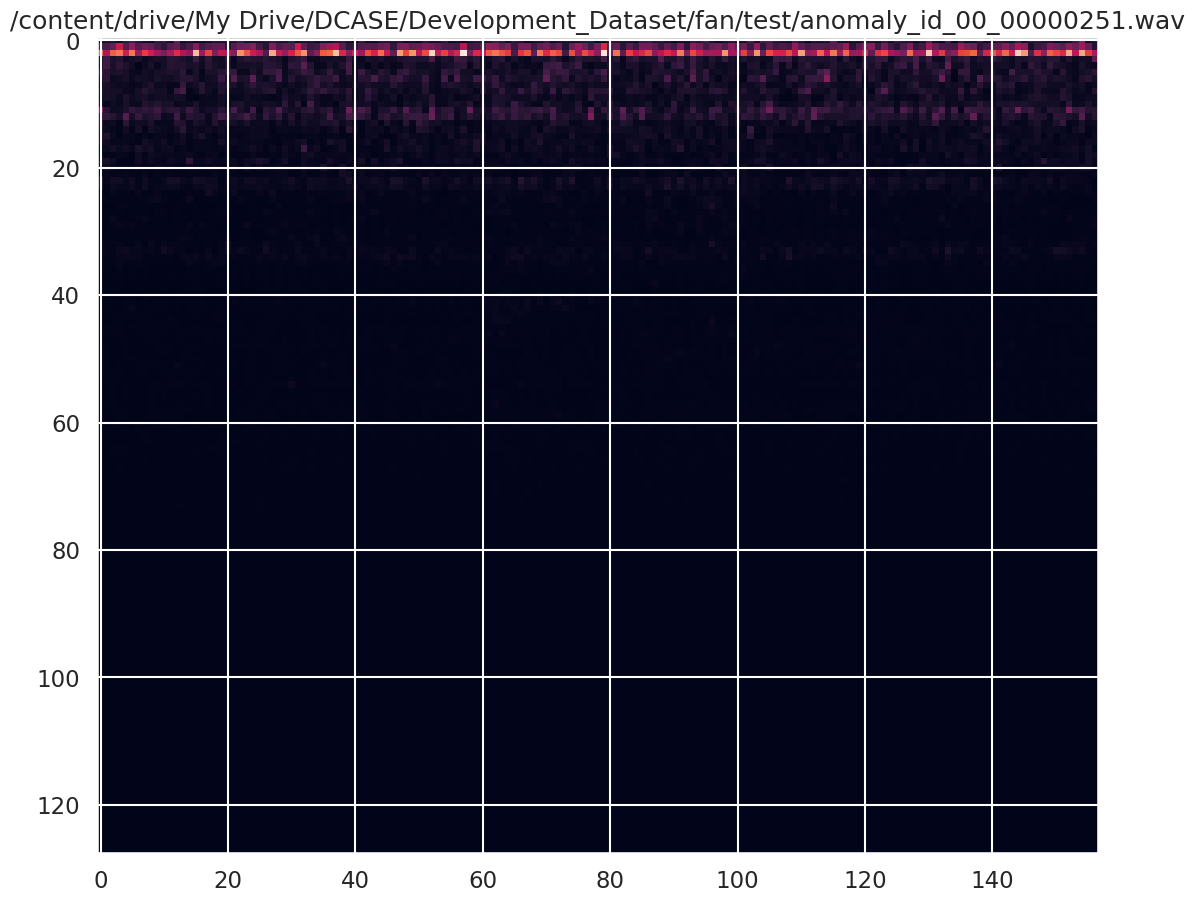

In [0]:
plt.figure(figsize = (19.2, 10.8), dpi = 100)
l = np.random.randint(0,X_test.shape[0])
plt.imshow(X_test[l,0].cpu())
plt.title(test_audiopaths[l])

In [0]:
s = model.prototype_visualize(X_test)

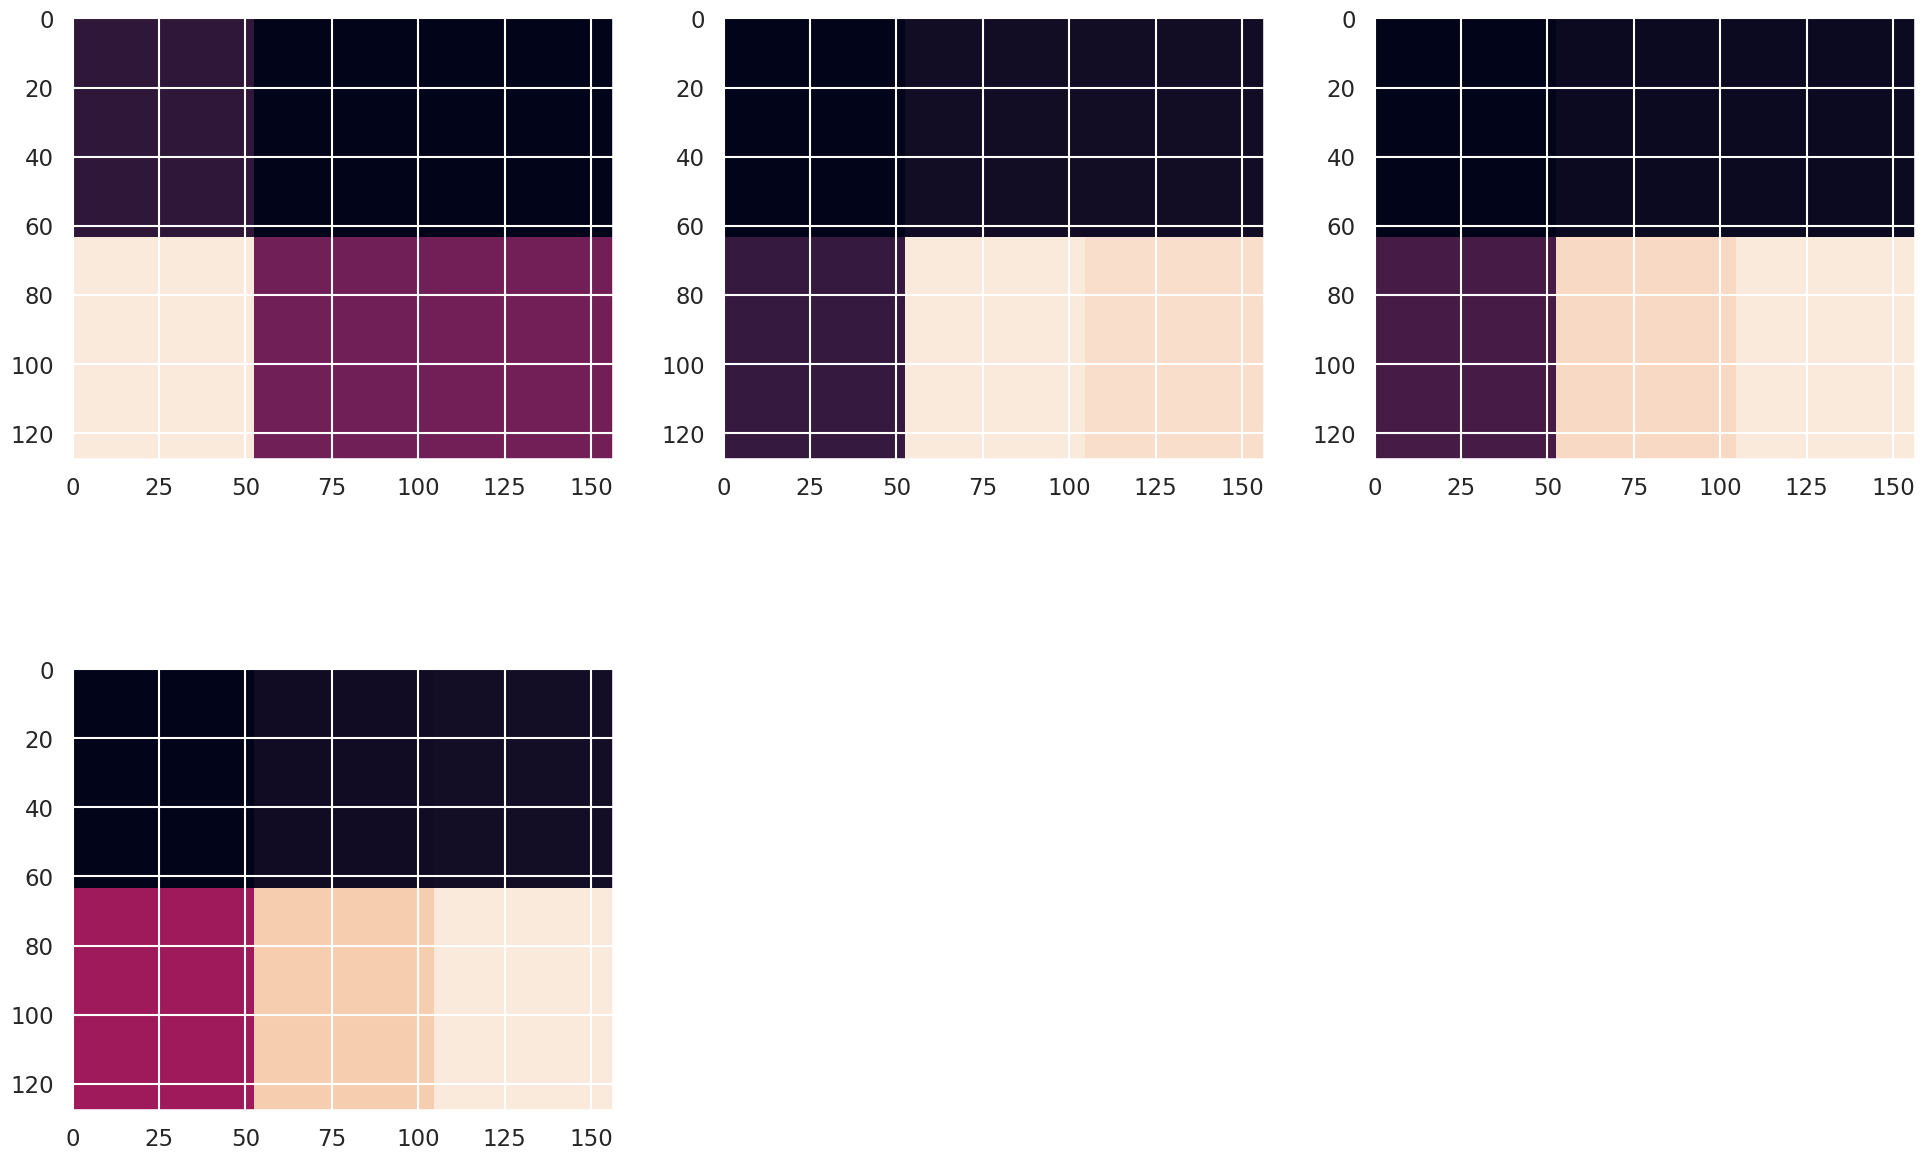

In [0]:
plt.figure(figsize = (23.8, 15.8), dpi = 100)
n, m = divmod(s.shape[1], 3)
for i in range(s.shape[1]):
    plt.subplot(n + m, 3, i + 1)
    plt.imshow(s[l, i].cpu())

# Evaluation Dataset


In [0]:
# 1) Check Architecture
# 2) Check Preprocessing

base_path = '/content/drive/My Drive/DCASE/Evaluation_Dataset'
machine_type = 'ToyConveyor'
machine_ids = ['04', '05', '06']

for machine_id in machine_ids:
    train_audiopaths = load(base_path + '/S128_%s_%s_train_audiopaths.joblib' % (machine_type, machine_id))
    test_audiopaths = load(base_path + '/S128_%s_%s_test_audiopaths.joblib' % (machine_type, machine_id))
    test_audiopaths = [fn.split('/')[-1] for fn in test_audiopaths]
    
    S_train = np.load(base_path + '/S128_%s_%s_train.npy' % (machine_type, machine_id))
    S_test = np.load(base_path + '/S128_%s_%s_test.npy' % (machine_type, machine_id))


    # Preprocessing
    X_train = torch.tensor(10 * np.log10(S_train + sys.float_info.epsilon), dtype = torch.float)
    X_train = X_train.view(X_train.shape[0], 1, *X_train.shape[1:]).to(device)

    X_test = torch.tensor(10 * np.log10(S_test + sys.float_info.epsilon), dtype = torch.float)
    X_test = X_test.view(X_test.shape[0], 1, *X_test.shape[1:]).to(device)
    
    # initialize model #
    model = AProtoPNet().to(device)   

    # Train Model 
    print('-' * 25)
    print('Training Model [ID = %s]' % machine_id)
    print('-' * 25)
    model.train_m(X_train) 

    with torch.no_grad():
        # Evaluate On X_test
        Y_pred = model(X_test)
        y_score = Y_pred.min(dim = 1)[0].cpu().numpy()        
        df = pd.DataFrame({'filename': test_audiopaths, 'Anomaly_Score': y_score})
        df.to_csv('anomaly_score_%s_id_%s.csv' % (machine_type, machine_id), header = False, index = False)
        

-------------------------
Training Model [ID = 04]
-------------------------
Epoch [0] Train_Loss 6.4994e+00, Val_Loss 3.3972e+00
Saving Model

Epoch [1] Train_Loss 2.3398e+00, Val_Loss 1.4572e+00
Saving Model

Epoch [2] Train_Loss 8.9962e-01, Val_Loss 5.4377e-01
Saving Model

Epoch [3] Train_Loss 4.4143e-01, Val_Loss 3.5744e-01
Saving Model

Epoch [4] Train_Loss 3.3272e-01, Val_Loss 2.7976e-01
Saving Model

Epoch [5] Train_Loss 3.1565e-01, Val_Loss 2.8436e-01
Epoch [6] Train_Loss 2.4743e-01, Val_Loss 2.2792e-01
Saving Model

Epoch [7] Train_Loss 2.1554e-01, Val_Loss 2.0167e-01
Saving Model

Epoch [8] Train_Loss 1.9445e-01, Val_Loss 1.8104e-01
Saving Model

Epoch [9] Train_Loss 1.7691e-01, Val_Loss 1.6454e-01
Saving Model

Epoch [10] Train_Loss 1.8077e-01, Val_Loss 1.5402e-01
Saving Model

Epoch [11] Train_Loss 1.5623e-01, Val_Loss 1.4042e-01
Saving Model

Epoch [12] Train_Loss 1.4292e-01, Val_Loss 1.2955e-01
Saving Model

Epoch [13] Train_Loss 1.3333e-01, Val_Loss 1.2218e-01
Saving Mo